The goal of this project is to predict the causes of wildfires with given data such as location, day of the week and so on.
* Part 1: Preprocessing
* Part 2: EDA
* Part 3: Using ML to predict the cause of the fires
* Part 4: Predicts if the fire was malicious

## Part 1: Preprocessing

In [1]:
#importing all relevant packages for this project

import geopandas as gpd
import pandas as pd
import descartes
from shapely.geometry import Point, Polygon
import contextily as cx


Bad key "text.kerning_factor" on line 4 in
C:\Users\Synergy\AppData\Local\conda\conda\envs\threeseven\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import tree, preprocessing
from sklearn.metrics import confusion_matrix
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

### importing the US map to visualize on

In [3]:
zipfile = "map/cb_2018_us_state_500k.shp"
states = gpd.read_file(zipfile)
state_codes = pd.read_excel('STATE_Codes.xlsx')

In [4]:
state_codes['Time Zone'].value_counts()

EST    21
CST    17
MST     7
PST     4
Name: Time Zone, dtype: int64

In [5]:
states = states[states.STUSPS.isin(state_codes['State Code'])] # mainland US

In [6]:
states_wm = states.to_crs(epsg=3857)

In [7]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

We can use the above function to establish a connection with the database file.

In [8]:
normalized_database_filename = 'FPA_FOD_20170508.sqlite'
cnx = create_connection(normalized_database_filename)

Then we can create our data frame by running a select query on the DB.

### All Columns

In [9]:
pd.read_sql_query("SELECT * FROM Fires limit 5", cnx).columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [10]:
selected_cols = "FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE".split(',')

In [11]:
selected_cols

['FIRE_YEAR',
 'STAT_CAUSE_DESCR',
 'LATITUDE',
 'LONGITUDE',
 'STATE',
 'DISCOVERY_DATE',
 'FIRE_SIZE']

### Querying the data

In [12]:
df = pd.read_sql_query("""SELECT FIRE_YEAR,
                                 STAT_CAUSE_DESCR,
                                 LATITUDE,
                                 LONGITUDE,
                                 STATE,
                                 DISCOVERY_DATE,
                                 FIRE_SIZE FROM Fires where fire_year > 2009""", cnx)
display(df.head())

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2010,Equipment Use,36.766944,-121.303056,CA,2455335.5,70.0
1,2010,Miscellaneous,36.776944,-121.311111,CA,2455355.5,0.5
2,2010,Miscellaneous,36.856111,-121.381111,CA,2455359.5,0.1
3,2010,Miscellaneous,36.818056,-121.391111,CA,2455361.5,0.1
4,2010,Miscellaneous,36.883056,-121.561944,CA,2455388.5,1.0


In [13]:
df.FIRE_YEAR.describe().round()

count    450234.0
mean       2012.0
std           2.0
min        2010.0
25%        2011.0
50%        2012.0
75%        2014.0
max        2015.0
Name: FIRE_YEAR, dtype: float64

### converting the date to right format

In [14]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
display(df.head())

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE
0,2010,Equipment Use,36.766944,-121.303056,CA,2455335.5,70.0,2010-05-19
1,2010,Miscellaneous,36.776944,-121.311111,CA,2455355.5,0.5,2010-06-08
2,2010,Miscellaneous,36.856111,-121.381111,CA,2455359.5,0.1,2010-06-12
3,2010,Miscellaneous,36.818056,-121.391111,CA,2455361.5,0.1,2010-06-14
4,2010,Miscellaneous,36.883056,-121.561944,CA,2455388.5,1.0,2010-07-11


In [15]:
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday

In [16]:
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].replace({0:'Sunday' ,
                                               1:'Monday' ,
                                               2:'Tuesday' ,
                                               3:'Wednesday' ,
                                               4:'Thursday' ,
                                               5:'Friday' ,
                                               6:'Saturday'})

## Part 2: Exploratory Data Analysis (EDA)

In [17]:
pd.DataFrame(df.STAT_CAUSE_DESCR.value_counts())

,STAT_CAUSE_DESCR
Debris Burning,110874
Miscellaneous,99326
Lightning,61155
Arson,48926
Missing/Undefined,39314
Equipment Use,32670
Campfire,20399
Children,10086
Smoking,9849
Powerline,8714


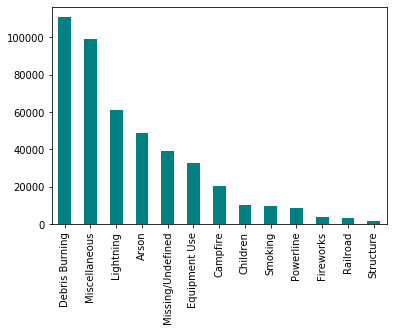

In [18]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar',color='teal')
plt.show()

13 causes are present in the dataset.

#### Are fires more likely on certain days of the week?

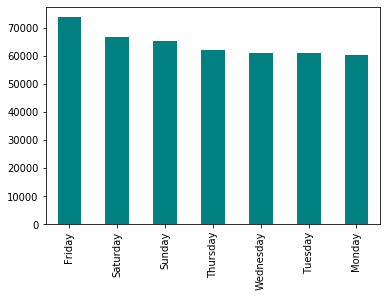

In [19]:
df['DAY_OF_WEEK'].value_counts().plot(kind='bar',color='teal')
plt.show()

Fires are a bit more likely to be discovered on the weekend. These fires can be due to people being careless with campfires or smoking or possibly malicious fires

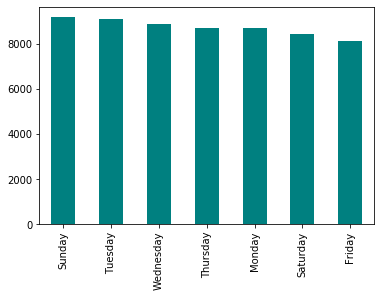

In [20]:
df_lightning = df[df['STAT_CAUSE_DESCR']=='Lightning']
df_lightning['DAY_OF_WEEK'].value_counts().plot(kind='bar',color='teal')
plt.show()

 Natural causes such as lightning strikes don't increase at the weekend as in the above plot.

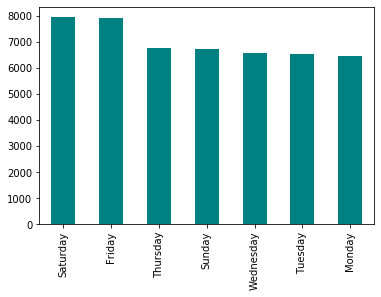

In [21]:
# checking if the spike on weekend is due to arson 
df_arson = df[df['STAT_CAUSE_DESCR']=='Arson']
df_arson['DAY_OF_WEEK'].value_counts().plot(kind='bar',color='teal')
plt.show()

Arson is more likely at the weekend than during the week, an increase of around 30% of the average for weekdays. So day of the week may be a useful feature to include in the model.

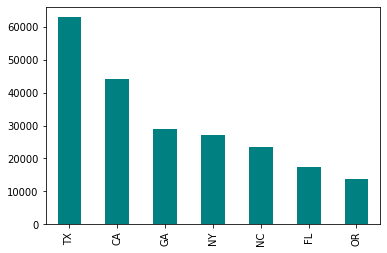

In [22]:
df['STATE'].value_counts().head(n=7).plot(kind='bar',color='teal')
plt.show()

In [23]:
df = df[df.STATE.isin(state_codes['State Code'])].reset_index(drop =True)

### Narrowing down to Western States

In [24]:
state_codes[state_codes['Time Zone'] == "PST"]

,State Code,Time Zone
3,CA,PST
31,NV,PST
35,OR,PST
45,WA,PST


In [25]:
df_West = pd.read_sql_query("""SELECT FIRE_YEAR,
                                      STAT_CAUSE_DESCR,
                                      LATITUDE,
                                      LONGITUDE,
                                      STATE,
                                      DISCOVERY_DATE,
                                      FIRE_SIZE FROM Fires
                                      WHERE fire_year > 2009
                                      AND STATE IN ('CA','NV','OR','WA')""", cnx)
display(df_West.head())

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2010,Equipment Use,36.766944,-121.303056,CA,2455335.5,70.0
1,2010,Miscellaneous,36.776944,-121.311111,CA,2455355.5,0.5
2,2010,Miscellaneous,36.856111,-121.381111,CA,2455359.5,0.1
3,2010,Miscellaneous,36.818056,-121.391111,CA,2455361.5,0.1
4,2010,Miscellaneous,36.883056,-121.561944,CA,2455388.5,1.0


In [26]:
df_West['DATE'] = pd.to_datetime(df_West['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df_West['MONTH'] = pd.DatetimeIndex(df_West['DATE']).month
df_West['DAY_OF_WEEK'] = df_West['DATE'].dt.weekday
df_West['DAY_OF_WEEK'] = df_West['DAY_OF_WEEK'].replace({0:'Sunday' ,
                                               1:'Monday' ,
                                               2:'Tuesday' ,
                                               3:'Wednesday' ,
                                               4:'Thursday' ,
                                               5:'Friday' ,
                                               6:'Saturday'})

In [27]:
df_West_orig = df_West.copy()

In [28]:
df_CA = df_West[df_West['STATE']=='CA']
df_OR = df_West[df_West['STATE']=='OR']
df_NV = df_West[df_West['STATE']=='NV']
df_WA = df_West[df_West['STATE']=='WA']

In [67]:
df_West_orig.groupby(['STAT_CAUSE_DESCR']).FIRE_SIZE.describe().sort_values('mean', ascending =False)

,count,mean,std,min,25%,50%,75%,max
STAT_CAUSE_DESCR,,,,,,,,
Structure,179.0,522.732626,5429.655774,0.010,0.1,0.10,0.500,69363.0
Lightning,16648.0,423.040799,7848.188391,0.010,0.1,0.10,0.500,558198.3
Equipment Use,6066.0,103.046718,3043.872008,0.010,0.1,0.25,1.000,218138.0
Miscellaneous,13829.0,80.117443,2481.093934,0.001,0.1,0.25,1.000,255858.0
Missing/Undefined,12341.0,59.508178,1414.456742,0.010,0.1,0.25,1.000,97717.0
Arson,4448.0,54.757035,1353.746904,0.010,0.1,0.20,1.000,64007.7
Railroad,127.0,48.686220,198.302773,0.010,0.1,0.30,2.200,1418.0
Powerline,702.0,40.348661,463.235048,0.010,0.1,0.25,1.175,10720.6
Campfire,5231.0,26.233749,1093.702723,0.010,0.1,0.10,0.100,75431.0


In [30]:
df_West.STATE.value_counts()

CA    44128
OR    13659
WA     8190
NV     3637
Name: STATE, dtype: int64

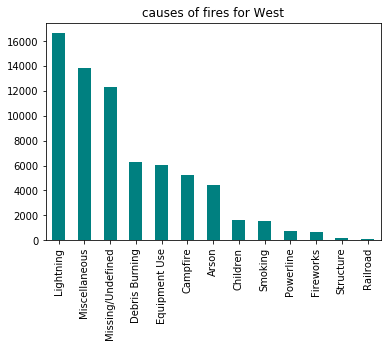

In [31]:
df_West['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar',color='teal',title='causes of fires for West')
plt.show()

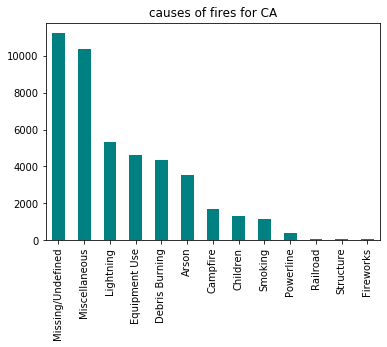

In [32]:
df_CA['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar',color='teal',title='causes of fires for CA')
plt.show()

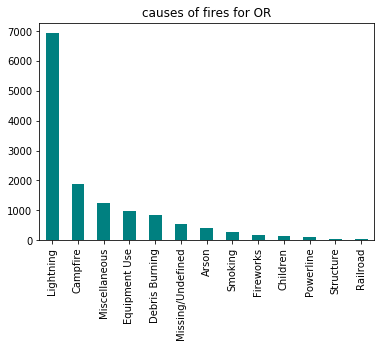

In [33]:
df_OR['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar',color='teal',title='causes of fires for OR')
plt.show()

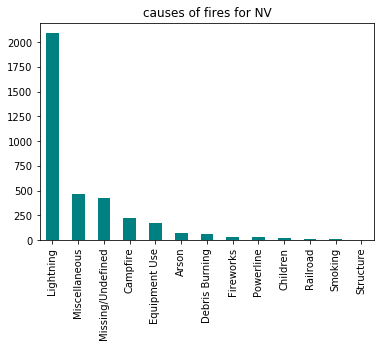

In [34]:
df_NV['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar',color='teal',title='causes of fires for NV')
plt.show()

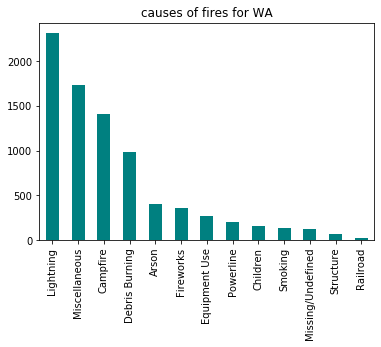

In [35]:
df_WA['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar',color='teal',title='causes of fires for WA')
plt.show()

We observe that Wildfires are different for different regions. Hence, we will be using 'STATE' as an important feature in this model. We can locate fire in this dataset with 'State' or 'Latitude and Longitude'.

We will plot different pairs of latitude and longitude in order to get the geographical view of the fires.


In [36]:
pd.DataFrame(df_West.STAT_CAUSE_DESCR.value_counts()/len(df_West)).sort_index()

,STAT_CAUSE_DESCR
Arson,0.063895
Campfire,0.075143
Children,0.023415
Debris Burning,0.089810
Equipment Use,0.087138
Fireworks,0.008949
Lightning,0.239147
Miscellaneous,0.198653
Missing/Undefined,0.177278
Powerline,0.010084


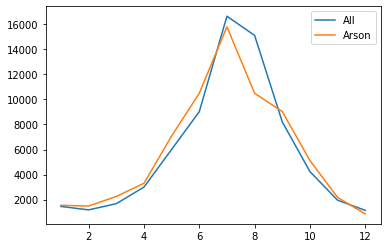

In [37]:
plt.plot((df_West_orig.MONTH.value_counts().sort_index()),label = "All")

plt.plot((df_West_orig[df_West_orig.STAT_CAUSE_DESCR == 'Arson'].MONTH.value_counts().sort_index())/0.063895, label = "Arson")

plt.legend()
plt.show()

Fires are more likely in summer for (holds for all fires and Arson) 

In [38]:
# Western State Map
states_west = states[states.STUSPS.isin(df_West.STATE)]

## Plotting different kinds of fire across western US
### Size of each datapoint is proportional to the firesize

In [39]:
df_West['FIRE_SIZE'] = df_West_orig['FIRE_SIZE']

In [40]:
df_West['FIRE_SIZE'] = 20*np.log1p(df_West.FIRE_SIZE)

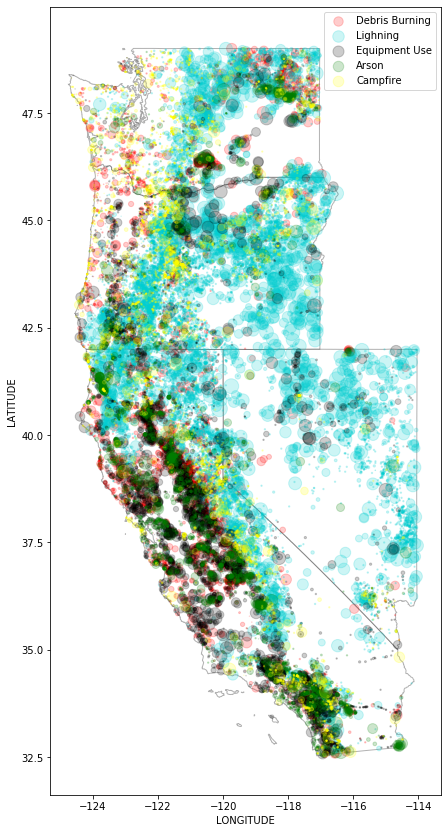

In [41]:
ax  = states_west.plot(figsize=(7,15), alpha=0.3, edgecolor='k', color = 'white')
df_West[df_West.STAT_CAUSE_DESCR == 'Debris Burning'].plot(label = 'Debris Burning',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='red',alpha=0.20, s = "FIRE_SIZE")
df_West[df_West.STAT_CAUSE_DESCR == 'Lightning'].plot(label = 'Lighning',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='darkturquoise',alpha=0.20, s = "FIRE_SIZE")
df_West[df_West.STAT_CAUSE_DESCR == 'Equipment Use'].plot(label = 'Equipment Use',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='black',alpha=0.20, s = "FIRE_SIZE")
df_West[df_West.STAT_CAUSE_DESCR == 'Arson'].plot(label = 'Arson',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='green',alpha=0.20, s = "FIRE_SIZE")
df_West[df_West.STAT_CAUSE_DESCR == 'Campfire'].plot(label = 'Campfire',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='yellow',alpha=0.20, s = "FIRE_SIZE")
plt.savefig('plots/west_fires.png', dpi = 100)

### without lightning

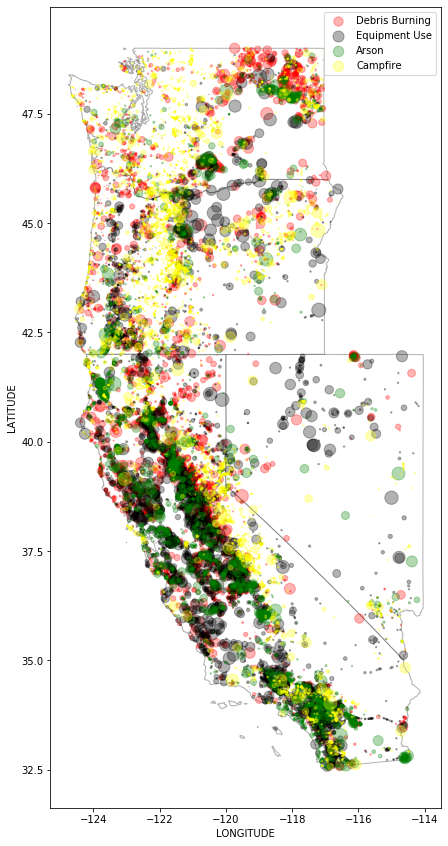

In [42]:
ax  = states_west.plot(figsize=(7,15), alpha=0.3, edgecolor='k', color = 'white')
df_West[df_West.STAT_CAUSE_DESCR == 'Debris Burning'].plot(label = 'Debris Burning',
                                                           ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',
                                                           color='red',alpha=0.30,
                                                           s = 'FIRE_SIZE')
df_West[df_West.STAT_CAUSE_DESCR == 'Equipment Use'].plot(label = 'Equipment Use',
                                                          ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',
                                                          color='black',alpha=0.30,
                                                          s = 'FIRE_SIZE')
df_West[df_West.STAT_CAUSE_DESCR == 'Arson'].plot(label = 'Arson',
                                                  ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',
                                                  color='green',alpha=0.30,
                                                  s = 'FIRE_SIZE')
df_West[df_West.STAT_CAUSE_DESCR == 'Campfire'].plot(label = 'Campfire',
                                                     ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',
                                                     color='yellow',alpha=0.30,
                                                     s = 'FIRE_SIZE')
plt.savefig('plots/except_lighning_fires.png', dpi = 100)

### Debris Burning

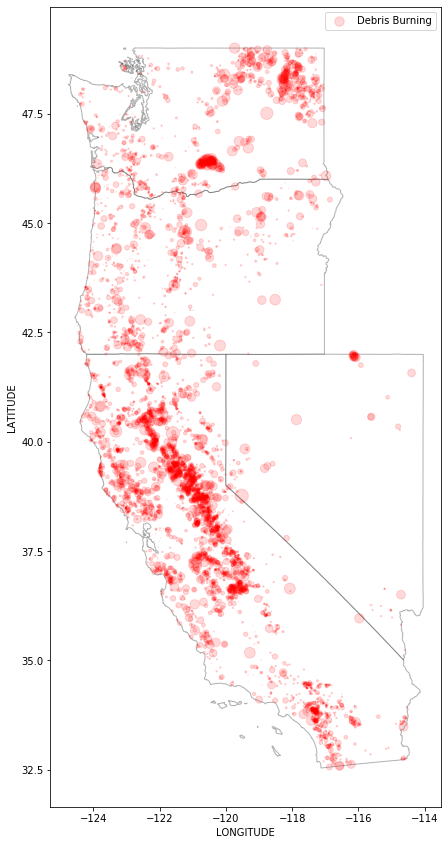

In [43]:
ax  = states_west.plot(figsize=(7,15), alpha=0.3, edgecolor='k', color = 'white')

df_West[df_West.STAT_CAUSE_DESCR == 'Debris Burning'].plot(label = 'Debris Burning',
                                                           ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',
                                                           color='red',alpha=0.15,
                                                           s = 'FIRE_SIZE')

### Arson

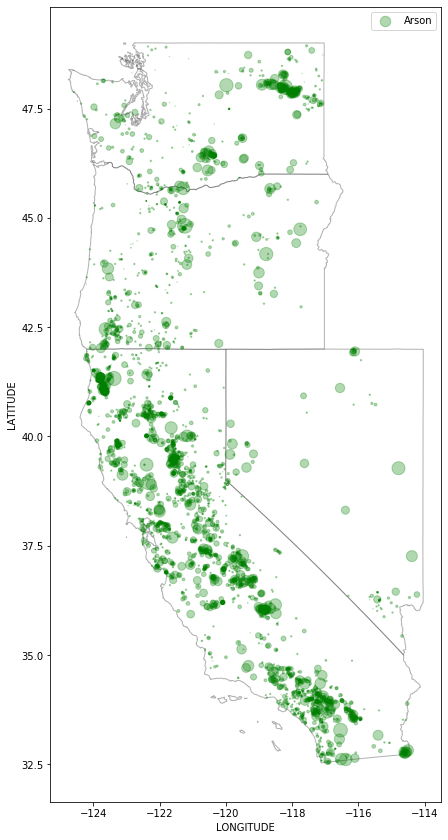

In [44]:
df_West = df_West_orig.copy()
df_West['FIRE_SIZE'] = 20*np.log1p(df_West.FIRE_SIZE)
ax  = states_west.plot(figsize=(7,15), alpha=0.3, edgecolor='k', color = 'white')
df_West[df_West.STAT_CAUSE_DESCR == 'Arson'].plot(label = 'Arson',
                                                  ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',
                                                  color='green',alpha=0.30,
                                                  s = 'FIRE_SIZE')

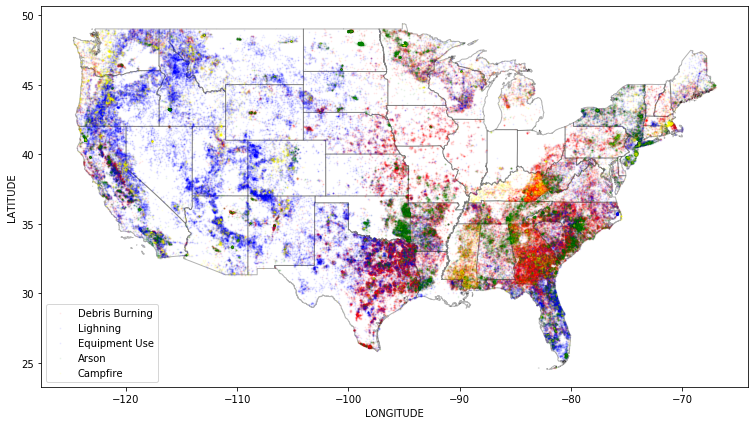

In [45]:
ax  = states.plot(figsize=(15, 7), alpha=0.3, edgecolor='k', color = 'white')
df[df.STAT_CAUSE_DESCR == 'Debris Burning'].plot(label = 'Debris Burning',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='red',alpha=0.05, s = 1)
df[df.STAT_CAUSE_DESCR == 'Lightning'].plot(label = 'Lighning',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='blue',alpha=0.05, s = 1)
df[df.STAT_CAUSE_DESCR == 'Equipment Use'].plot(label = 'Equipment Use',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='blue',alpha=0.05, s = 1)
df[df.STAT_CAUSE_DESCR == 'Arson'].plot(label = 'Arson',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='green',alpha=0.05, s = 1)
df[df.STAT_CAUSE_DESCR == 'Campfire'].plot(label = 'Campfire',ax = ax,kind='scatter',x='LONGITUDE',y='LATITUDE',color='yellow',alpha=0.05, s = 1)
plt.savefig('plots/all_US.png', dpi = 100)

### We can observe from the above plots that the fires are clustered and in western states and all accross US as well. So we believe its very important to utilize latitude and longitude

To understand the multicollinearity amongst the features, we look at the correlation matrix.

In [46]:
le = preprocessing.LabelEncoder()
df_West['STAT_CAUSE_DESCR'] = le.fit_transform(df_West['STAT_CAUSE_DESCR'])
df_West['STATE'] = le.fit_transform(df_West['STATE'])
df_West['DAY_OF_WEEK'] = le.fit_transform(df_West['DAY_OF_WEEK'])
display(df_West.head())

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK
0,2010,4,36.766944,-121.303056,0,2455335.5,85.253598,2010-05-19,5,5
1,2010,7,36.776944,-121.311111,0,2455355.5,8.109302,2010-06-08,6,1
2,2010,7,36.856111,-121.381111,0,2455359.5,1.906204,2010-06-12,6,0
3,2010,7,36.818056,-121.391111,0,2455361.5,1.906204,2010-06-14,6,3
4,2010,7,36.883056,-121.561944,0,2455388.5,13.862944,2010-07-11,7,2


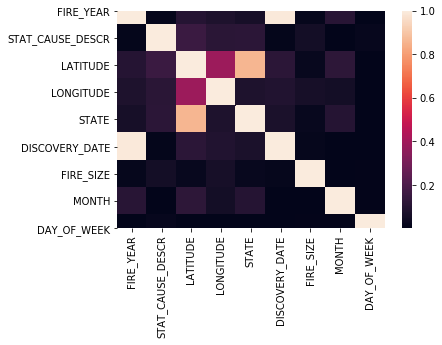

In [47]:
sns.heatmap(abs(df_West.corr()))

In the above diagram strong correlations are lighter, and white = zero correlation 

## Part 3
**Preparing the data for machine learning**

everything is converted to numeric data in above cells
Droping date and Nans

In [48]:
df_West = df_West.drop('DATE',axis=1)
df_West = df_West.dropna()

Here, we want to predict the cause of fire using 'STAT_CAUSE_DESCR'.

In [49]:
X = df_West.drop(['STAT_CAUSE_DESCR'], axis=1).values
y = df_West['STAT_CAUSE_DESCR'].values

Creating a data partition between training and test data such that they represent the original data

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) #30% for testing, 70% for training

In [51]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.5110845104141728


Splitting the causes of fires into 4 different classes- natural_fires, accidental_fires, malicious and other

In [52]:
def set_label(cat):
    case = 0
    natural_fires = ['Lightning']
    accidental_fires = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural_fires:
        case = 1
    elif cat in accidental_fires:
        case = 2
    elif cat in malicious:
        case = 3
    else:
        case = 4
    return case
     

df_West['LABEL'] = df_West_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) 
df_West = df_West.drop('STAT_CAUSE_DESCR',axis=1)
display(df_West.head())

,FIRE_YEAR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,MONTH,DAY_OF_WEEK,LABEL
0,2010,36.766944,-121.303056,0,2455335.5,85.253598,5,5,2
1,2010,36.776944,-121.311111,0,2455355.5,8.109302,6,1,4
2,2010,36.856111,-121.381111,0,2455359.5,1.906204,6,0,4
3,2010,36.818056,-121.391111,0,2455361.5,1.906204,6,3,4
4,2010,36.883056,-121.561944,0,2455388.5,13.862944,7,2,4


replacing STAT_CAUSE_DESCR with LABEL, to prdict it

In [53]:
X = df_West.drop(['LABEL'], axis=1).values
y = df_West['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [54]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.6553986114436198


When we reduced the number of categories, the prediction score improved remarkably from 58% to 70%. But it is always good to consider more metrics to evaluate the model, so we look at confusion matrix.

In [55]:
y_pred = clf_rf.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
display(cm)

array([[4454,  311,    8,  258],
       [ 502, 3503,   69, 2636],
       [  55,  320,  425,  528],
       [ 442, 1865,   93, 5416]], dtype=int64)

We can normalize this and visualize the result:

In [56]:
['predicted_'+ i for i in  ['natural_fires',
'accidental_fires',
'malicious',
'others']]

['predicted_natural_fires',
 'predicted_accidental_fires',
 'predicted_malicious',
 'predicted_others']

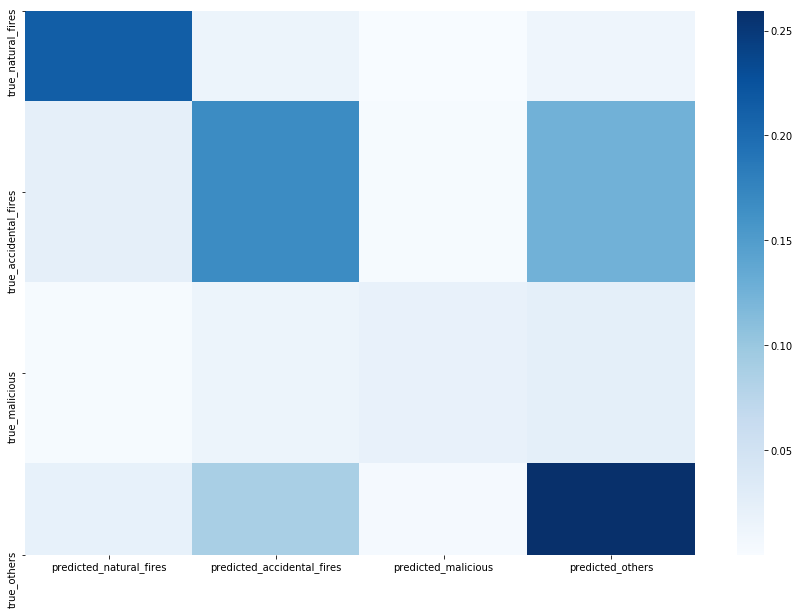

In [57]:
plt.figure(figsize = (15,10))
sns.heatmap(pd.DataFrame(cm/len(X_test), index = ['true_natural_fires',
 'true_accidental_fires',
 'true_malicious',
 'true_others'], columns = ['predicted_natural_fires',
 'predicted_accidental_fires',
 'predicted_malicious',
 'predicted_others']), cmap='Blues')

The random forest showed good performance with natural_fires and accidental_fires but did poorly with the other classes, especially with the malicious! So our conclusion is that while we can accurately predict some causes of wildfire, further tuning the algorithm might probably improve prediction of other classes as well. 

In [58]:
df_West = df_West_orig.copy()

Create a new field: ARSON

In [59]:
df_West['ARSON'] = (df_West['STAT_CAUSE_DESCR'] == 'Arson').astype(int)
display(df_West.head())

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DATE,MONTH,DAY_OF_WEEK,ARSON
0,2010,Equipment Use,36.766944,-121.303056,CA,2455335.5,70.0,2010-05-19,5,Tuesday,0
1,2010,Miscellaneous,36.776944,-121.311111,CA,2455355.5,0.5,2010-06-08,6,Monday,0
2,2010,Miscellaneous,36.856111,-121.381111,CA,2455359.5,0.1,2010-06-12,6,Friday,0
3,2010,Miscellaneous,36.818056,-121.391111,CA,2455361.5,0.1,2010-06-14,6,Sunday,0
4,2010,Miscellaneous,36.883056,-121.561944,CA,2455388.5,1.0,2010-07-11,7,Saturday,0


We can drop the DATE, STATE, FIRE_SIZE and STAT_CAUSE_DESCR fields and convert the DAY_OF_WEEK to numerical values.

In [60]:
df_West = df_West.drop('DATE',axis=1)
df_West = df_West.drop('STATE',axis=1)
df_West = df_West.drop('STAT_CAUSE_DESCR',axis=1)
df_West = df_West.drop('FIRE_SIZE',axis=1)
df_West = df_West.dropna()

le = preprocessing.LabelEncoder()
df_West['DAY_OF_WEEK'] = le.fit_transform(df_West['DAY_OF_WEEK'])

display(df_West.head())

,FIRE_YEAR,LATITUDE,LONGITUDE,DISCOVERY_DATE,MONTH,DAY_OF_WEEK,ARSON
0,2010,36.766944,-121.303056,2455335.5,5,5,0
1,2010,36.776944,-121.311111,2455355.5,6,1,0
2,2010,36.856111,-121.381111,2455359.5,6,0,0
3,2010,36.818056,-121.391111,2455361.5,6,3,0
4,2010,36.883056,-121.561944,2455388.5,7,2,0


We can now test the ML model

In [61]:
RandomForestClassifier = ske.RandomForestClassifier

In [62]:
X = df_West.drop(['ARSON'], axis=1).values
y = df_West['ARSON'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) #30% for testing, 70% for training
classifier_rf = ske.RandomForestClassifier(n_estimators=200)
classifier_rf = classifier_rf.fit(X_train, y_train)
print(classifier_rf.score(X_test,y_test).round(5)*100)

95.159


We have predicted the fire with 95% accuracy to be Arson.

In [63]:
feature_imp = pd.DataFrame([df_West.drop(['ARSON'], axis=1).columns, classifier_rf.feature_importances_], index = ['feature','feature imp']).T

In [64]:
display(feature_imp)

,feature,feature imp
0,FIRE_YEAR,0.0264444
1,LATITUDE,0.330981
2,LONGITUDE,0.359621
3,DISCOVERY_DATE,0.175095
4,MONTH,0.0482805
5,DAY_OF_WEEK,0.0595788


Summary:
We can predict the chances of fire being due to Arson with 95% accuracy.